In [111]:
import pandas as pd
from pandas import Series, DataFrame

In [112]:
df=pd.read_csv(r'E:\\AAPL.csv')

In [113]:
df['datetime'] = pd.to_datetime(df['Date'])

In [114]:
df = df.set_index('datetime')

In [115]:
df.drop(['Date'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
datetime,,,,,,
2009-12-31,30.447144,30.478571,30.080000,30.104286,26.272409,88102700
2010-01-04,30.490000,30.642857,30.340000,30.572857,26.681330,123432400
2010-01-05,30.657143,30.798571,30.464285,30.625713,26.727465,150476200
2010-01-06,30.625713,30.747143,30.107143,30.138571,26.302330,138040000
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.253704,119282800


In [116]:
hdf.index.dtype

dtype('<M8[ns]')

In [117]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
datetime,,,,
2009-12-31,26.272409,88102700,1.323968,-1.126076
2010-01-04,26.681330,123432400,0.990607,0.271751
2010-01-05,26.727465,150476200,1.091521,-0.102521
2010-01-06,26.302330,138040000,2.123525,-1.590631
2010-01-07,26.253704,119282800,1.400894,-0.552539


In [118]:
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(2433, 4)
Dimension of X (2408, 4)
Dimension of y (2408,)


In [119]:

# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)


In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Lasso regression
clflasso=Lasso()
clflasso.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [121]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidencelasso= clflasso.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print('The lasso regression confidence is ', confidencelasso)

The linear regression confidence is  0.9685018327102646
The quadratic regression 2 confidence is  0.9692003553075909
The quadratic regression 3 confidence is  0.9489856855446802
The lasso regression confidence is  0.967933419395599


In [122]:
# Printing the forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan


In [123]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

In [124]:
last_unix = last_date
dfreg.iloc[-1].name

Timestamp('2019-09-24 00:00:00')

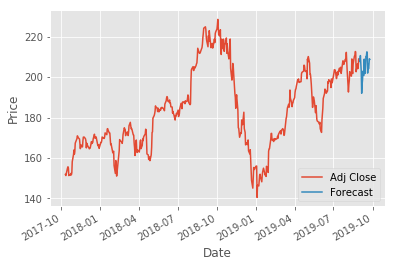

In [125]:

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()